In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from tqdm import tqdm

import tensorflow as tf

import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../input/utk-face-extracted-info/extracted_info.csv')
df.dropna(inplace=True)
df = df[df['Age'] <= 90]
df = df[df['Age'] >= 0]
df = df.reset_index()
df = df.drop(columns = {'DateTime', 'Unnamed: 0', 'index'})
df['Name'] = df['Name'].apply(lambda x: '../input/utkface-new/UTKFace/' + str(x))

num_classes = len(df['Age'].unique())
df.head()

,Age,Gender,Race,Name
0,26,0,2,../input/utkface-new/UTKFace/26_0_2_2017010402...
1,22,1,1,../input/utkface-new/UTKFace/22_1_1_2017011223...
2,21,1,3,../input/utkface-new/UTKFace/21_1_3_2017010500...
3,28,0,0,../input/utkface-new/UTKFace/28_0_0_2017011718...
4,17,1,4,../input/utkface-new/UTKFace/17_1_4_2017010322...


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Gender'}>],
       [<AxesSubplot:title={'center':'Race'}>, <AxesSubplot:>]],
      dtype=object)

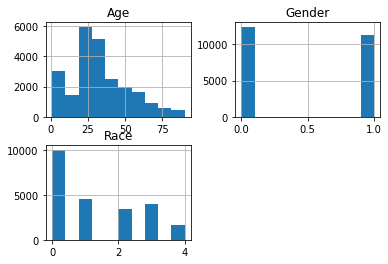

In [3]:
df.hist()

In [4]:
'''
len(df[df['Age']>93]['Age']) ------- just 46 people
classes = 101 #(0, 100])
print("number of output classes: ",classes)
'''

df['Age'] = df['Age'] - 1

In [5]:
df_data = df.Name
y_data = df.Age
y2_data = df.Gender
X_train, X_test, y_train, y_test = train_test_split(df_data, y_data, test_size=0.20, random_state=40)
d = {'Name':X_train,'Age':y_train}
df_train = pd.concat(d,axis=1)
df_train.head(3)

,Name,Age
2962,../input/utkface-new/UTKFace/15_1_2_2017011617...,14
15308,../input/utkface-new/UTKFace/1_0_2_20161219141...,0
5767,../input/utkface-new/UTKFace/40_0_2_2017011619...,39


In [6]:
df_data = df_train.Name
y_data = df_train.Age
y2_data = df.Gender
X_train, X_val, y_train, y_val = train_test_split(df_data, y_data, test_size=0.1, random_state=42)
d = {'Name':X_train,'Age':y_train}
train = pd.concat(d,axis=1)
train.head(3)

,Name,Age
17222,../input/utkface-new/UTKFace/1_1_0_20161219204...,0
18129,../input/utkface-new/UTKFace/51_0_0_2017011717...,50
16153,../input/utkface-new/UTKFace/4_1_3_20161219230...,3


In [7]:
d = {'Name':X_val,'Age':y_val}
val = pd.concat(d,axis=1)
print(val.head(3))
###################
d = {'Name':X_test,'Age':y_test}
df_test = pd.concat(d,axis=1)
print(df_test.head(3))

                                                    Name  Age
8214   ../input/utkface-new/UTKFace/58_0_0_2017011119...   57
15208  ../input/utkface-new/UTKFace/1_0_3_20161220142...    0
18596  ../input/utkface-new/UTKFace/51_0_1_2017011716...   50
                                                    Name  Age
5730   ../input/utkface-new/UTKFace/28_0_3_2017011621...   27
10893  ../input/utkface-new/UTKFace/49_1_0_2017010420...   48
4617   ../input/utkface-new/UTKFace/24_0_1_2017011313...   23


In [8]:
train['Age'] = train['Age'].astype('str')
df_test['Age'] = df_test['Age'].astype('str')
val['Age'] = val['Age'].astype('str')

In [9]:
print(len(train['Age'].unique()),"\n", val['Age'])
print(len(train))
len(df[df['Age']>=80])

90 
 8214     57
15208     0
18596    50
9997     53
15876    57
         ..
7281     24
14461     2
885      44
1729     21
15754    59
Name: Age, Length: 1890, dtype: object
17004


453

In [10]:
batch = 512
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
train_data = train_gen.flow_from_dataframe(dataframe = train, 
                                           #directory = train_folder, 
                                           x_col = 'Name',
                                           y_col = 'Age', seed = 42,
                                           batch_size = batch,
                                           shuffle = True, 
                                           class_mode="sparse",
                                           target_size = (224, 224))

test_data = test_gen.flow_from_dataframe(dataframe = df_test,
                                         #directory = test_folder,
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))

val_data = train_gen.flow_from_dataframe(dataframe = val, 
                                           #directory = train_folder, 
                                           x_col = 'Name',
                                           y_col = 'Age', seed = 42,
                                           batch_size = batch,
                                           shuffle = True, 
                                           class_mode="sparse",
                                           target_size = (224, 224))

Found 17004 validated image filenames belonging to 90 classes.
Found 4724 validated image filenames belonging to 90 classes.
Found 1890 validated image filenames belonging to 89 classes.


In [11]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

model.load_weights('../input/vggfaceweights/vgg_face_weights.h5')

In [12]:
model_selection = 0
model.output_shape

(None, 2622)

In [13]:
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes))

model.add(Activation('softmax'))

for layer in model.layers[:-6]:
    layer.trainable = False

model.compile(
  optimizer='adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

In [14]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs= 10,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/10
34/34 [==============================] - 138s 4s/step - loss: 4.4794 - accuracy: 0.0792 - val_loss: 4.3607 - val_accuracy: 0.0952
Epoch 2/10
34/34 [==============================] - 56s 2s/step - loss: 4.2962 - accuracy: 0.0939 - val_loss: 4.1153 - val_accuracy: 0.0952
Epoch 3/10
34/34 [==============================] - 56s 2s/step - loss: 4.0927 - accuracy: 0.0924 - val_loss: 4.0592 - val_accuracy: 0.0952
Epoch 4/10
34/34 [==============================] - 56s 2s/step - loss: 4.0435 - accuracy: 0.0930 - val_loss: 4.0564 - val_accuracy: 0.0952
Epoch 5/10
34/34 [==============================] - 57s 2s/step - loss: 4.0543 - accuracy: 0.0932 - val_loss: 4.0578 - val_accuracy: 0.0952


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

In [16]:
A = model.predict_classes(test_data)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [17]:
df_test['Predictions'] = A
df_test.to_csv('Final')

In [18]:
MAE = 0
for i in range(len(df_test)):
    MAE = MAE + abs(int(df_test.iloc[i]['Age']) - int(df_test.iloc[i]['Predictions']))
print("MAE is ", MAE/len(df_test))

MAE is  18.720152413209146
